## 🧠 Model Training

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
trainwdrop_log = pd.read_csv('../dataset/cleanedwdrop_log_encode_sales_data.csv')
trainwfill_log = pd.read_csv('../dataset/cleanedwfill_log_encode_sales_data.csv')
trainwdrop_iso = pd.read_csv('../dataset/cleanedwdrop_iso_encode_sales_data.csv')
trainwfill_iso = pd.read_csv('../dataset/cleanedwfill_iso_encode_sales_data.csv')

In [3]:
trainwdrop_log.drop(columns=['year'], inplace=True)
trainwdrop_iso.drop(columns=['year'], inplace=True)

trainwfill_log.drop(columns=['year', 'manufacturer', 'model'], inplace=True)
trainwfill_iso.drop(columns=['year', 'manufacturer', 'model'], inplace=True)

In [4]:
#odometer can car_age into int
trainwdrop_log['car_age'] = trainwdrop_log['car_age'].astype(int)
trainwdrop_iso['car_age'] = trainwdrop_iso['car_age'].astype(int)
trainwfill_log['car_age'] = trainwfill_log['car_age'].astype(int)
trainwfill_iso['car_age'] = trainwfill_iso['car_age'].astype(int)

trainwdrop_log['odometer'] = trainwdrop_log['odometer'].astype(int)
trainwdrop_iso['odometer'] = trainwdrop_iso['odometer'].astype(int)
trainwfill_log['odometer'] = trainwfill_log['odometer'].astype(int)
trainwfill_iso['odometer'] = trainwfill_iso['odometer'].astype(int)

In [5]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42, verbosity=0, tree_method='gpu_hist')
}

In [6]:
datasets = {
    "Drop_Log": trainwdrop_log.copy(),
    "Drop_Iso": trainwdrop_iso.copy(),
    "Fill_Log": trainwfill_log.copy(),
    "Fill_Iso": trainwfill_iso.copy()
}

In [7]:
def evaluate(y, y_pred):
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    pmae = (mae / y.mean()) * 100
    return r2, rmse, mae, pmae

In [8]:
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_no_hyper_tune = []

# Total iterations = number of datasets * number of models
total_iters = len(datasets) * len(models)

# Create progress bar
pbar = tqdm(total=total_iters, desc="Evaluating Models", leave=True)

# --- LOOP THROUGH DATASETS & MODELS ---
for name, df in datasets.items():
    X = df.drop(columns=["price"])
    y = df["price"]

    for model_name, model in models.items():
        y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
        r2, rmse, mae, pmae = evaluate(y, y_pred)

        results_no_hyper_tune.append({
            "Dataset": name,
            "Model": model_name,
            "R²": round(r2, 4),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "PMAE (%)": round(pmae, 2)
        })

        # Update progress
        pbar.update(1)

pbar.close()


Evaluating Models:   0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Reds_r") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


,Dataset,Model,R²,RMSE,MAE,PMAE (%)
0,Drop_Log,LinearRegression,0.6535,"6,384.77","4,611.21",35.27
1,Drop_Log,RidgeRegression,0.6535,"6,384.77","4,611.21",35.27
2,Drop_Log,RandomForest,0.8916,"3,571.32","2,001.97",15.31
3,Drop_Log,XGBoost,0.8920,"3,564.99","2,216.08",16.95
4,Drop_Iso,LinearRegression,0.5603,"6,691.75","4,818.05",37.80
5,Drop_Iso,RidgeRegression,0.5603,"6,691.75","4,818.04",37.80
6,Drop_Iso,RandomForest,0.8799,"3,497.22","2,038.81",15.99
7,Drop_Iso,XGBoost,0.8704,"3,633.03","2,332.95",18.30
8,Fill_Log,LinearRegression,0.6900,"7,444.66","5,264.40",28.39
9,Fill_Log,RidgeRegression,0.6900,"7,444.66","5,264.40",28.39


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# for result in results_no_hyper_tune:
#     dataset_name = result["Dataset"]
#     model_name = result["Model"]

#     # Retrieve the corresponding dataset and model
#     df = datasets[dataset_name]
#     model = models[model_name]

#     X = df.drop(columns=["price"])
#     y = df["price"]

#     # Generate predictions using cross_val_predict
#     y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

#     # Plot the results
#     plt.figure(figsize=(18, 14))
#     plt.hexbin(y, y_pred, gridsize=70, mincnt=1, linewidths=0.5, edgecolors='gray', cmap='Blues', bins='log')
#     plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
#     plt.xlabel("Actual Price")
#     plt.ylabel("Predicted Price")
#     plt.title(f"{dataset_name} - {model_name}")
#     plt.colorbar(label="Density")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


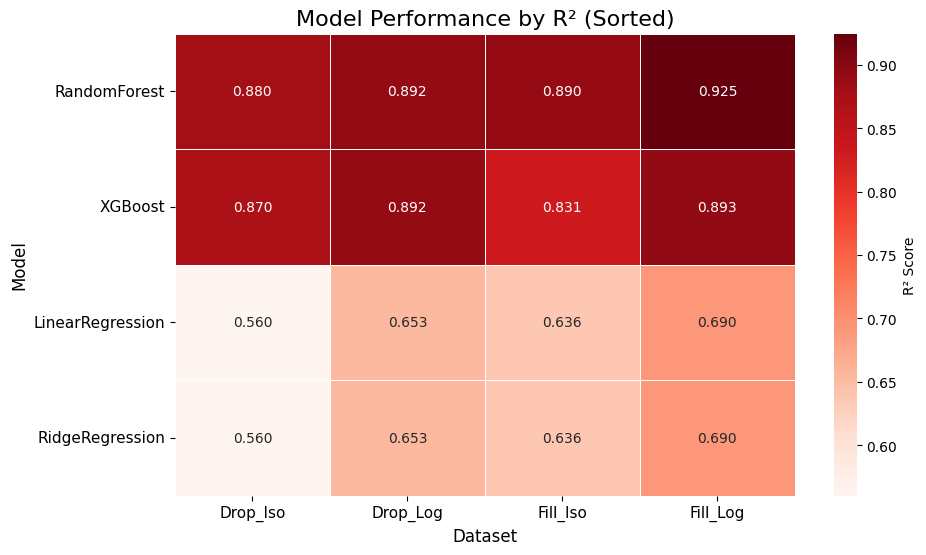

In [11]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index="Model", columns="Dataset", values="R²")

# Calculate the average R² and sort by it
heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
heatmap_data.drop(columns="Avg R²", inplace=True)

# Red theme color map
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Reds",          # red theme
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "R² Score"}
)

plt.title("Model Performance by R² (Sorted)", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [12]:
from sklearn.base import clone

# Prepare data
X_Fill = datasets["Fill_Log"].drop(columns=["price"])
y_Fill = datasets["Fill_Log"]["price"]

X_Drop = datasets["Drop_Log"].drop(columns=["price"])
y_Drop = datasets["Drop_Log"]["price"]

# Fit model
model = clone(models["RandomForest"]).fit(X, y)

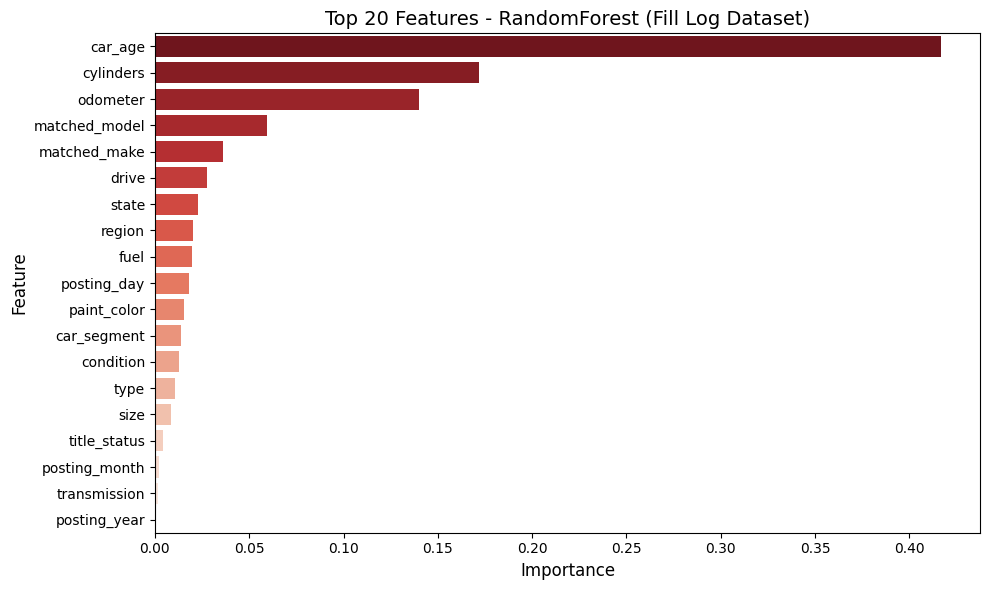

In [13]:
# Extract feature importances and select top 20
importances_fill = pd.Series(model.feature_importances_, index=X_Fill.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_fill.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Fill Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

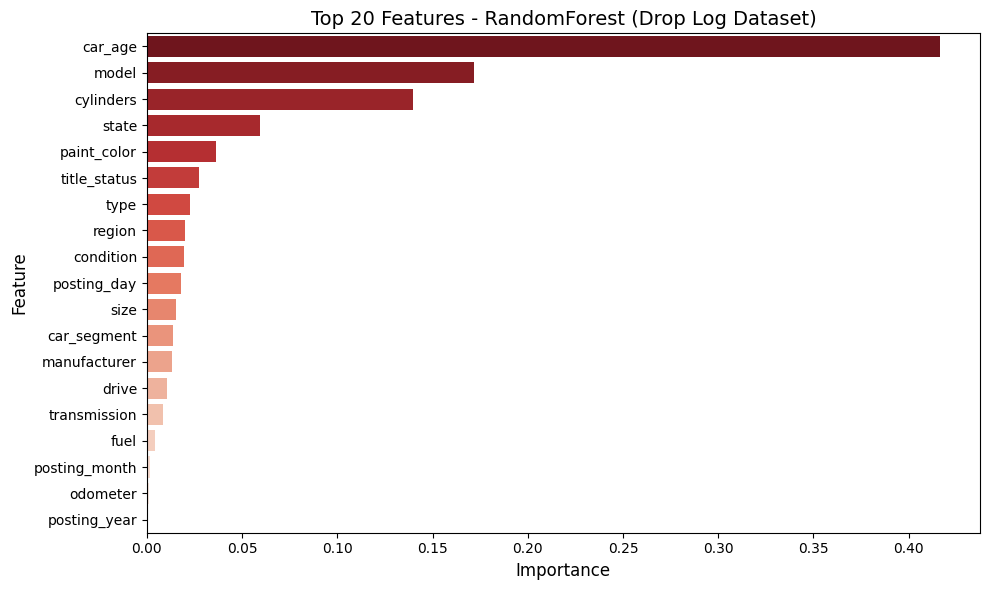

In [14]:
# Extract feature importances and select top 20
importances_drop = pd.Series(model.feature_importances_, index=X_Drop.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_drop.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Drop Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

note : redundency on car_age and year drop `year`

In [15]:
importances_fill * 100

car_age          41.658839
cylinders        17.175320
odometer         13.975871
matched_model     5.918651
matched_make      3.609138
drive             2.746318
state             2.271654
region            1.993686
fuel              1.976838
posting_day       1.789746
paint_color       1.548390
car_segment       1.366275
condition         1.300085
type              1.057283
size              0.836411
title_status      0.442145
posting_month     0.193731
transmission      0.139621
posting_year      0.000000
dtype: float64

In [16]:
importances_drop * 100

car_age          41.658839
model            17.175320
cylinders        13.975871
state             5.918651
paint_color       3.609138
title_status      2.746318
type              2.271654
region            1.993686
condition         1.976838
posting_day       1.789746
size              1.548390
car_segment       1.366275
manufacturer      1.300085
drive             1.057283
transmission      0.836411
fuel              0.442145
posting_month     0.193731
odometer          0.139621
posting_year      0.000000
dtype: float64

In [17]:
select_feature_fill = importances_fill[:18].index
select_feature_fill

Index(['car_age', 'cylinders', 'odometer', 'matched_model', 'matched_make',
       'drive', 'state', 'region', 'fuel', 'posting_day', 'paint_color',
       'car_segment', 'condition', 'type', 'size', 'title_status',
       'posting_month', 'transmission'],
      dtype='object')

In [18]:
select_feature_drop = importances_drop[:18].index
select_feature_drop

Index(['car_age', 'model', 'cylinders', 'state', 'paint_color', 'title_status',
       'type', 'region', 'condition', 'posting_day', 'size', 'car_segment',
       'manufacturer', 'drive', 'transmission', 'fuel', 'posting_month',
       'odometer'],
      dtype='object')

In [19]:
importances_fill[select_feature_fill].sum()

np.float64(1.0000000000000002)

In [20]:
importances_drop[select_feature_drop].sum()

np.float64(1.0000000000000002)

## 🛠️Feature Selection & Hypertune

In [21]:
datasets = {
    "Drop_Log": datasets["Drop_Log"][select_feature_drop.tolist() + ['price']].copy(),
    "Drop_Iso": datasets["Drop_Iso"][select_feature_drop.tolist() + ['price']].copy(),
    "Fill_Log": datasets["Fill_Log"][select_feature_fill.tolist() + ['price']].copy(),
    "Fill_Iso": datasets["Fill_Iso"][select_feature_fill.tolist() + ['price']].copy()
}

In [23]:
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import pandas as pd
import optuna

results_tuned = []
best_params = {}

# --- Early stopping callback ---
class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_value = float('inf')
        self.counter = 0

    def __call__(self, study, trial):
        if study.best_value < self.best_value:
            self.best_value = study.best_value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"⛔️ Early stopping triggered after {self.patience} trials.")
            study.stop()


In [30]:
# --- Tuning functions ---
def tune_ridge(trial, X, y):
    alpha = trial.suggest_float("alpha", 1e-5, 1e5, log=True)  # Extremely wide range for alpha
    model = Ridge(alpha=alpha)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_rf(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "max_depth": trial.suggest_int("max_depth", 11, 16), 
        "min_samples_split": trial.suggest_int("min_samples_split", 3, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 3), 
    }
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_xgb(trial, X, y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1500),
        'max_depth': trial.suggest_int('max_depth', 10, 16),
        
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'gpu_hist',
    }
    model = XGBRegressor(**params, n_jobs=-1)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 


In [31]:
import joblib
import os

# --- Main tuning loop ---
def run_tuning(dataset_name, model_name, datasets, n_trials=None, patience=None):
    X = datasets[dataset_name].drop(columns=["price"])
    y = datasets[dataset_name]["price"]

    # Check if the model has already been trained on this dataset
    existing_result_index = next(
        (i for i, result in enumerate(results_tuned) 
         if result["Dataset"] == dataset_name and result["Model"].startswith(model_name)), 
        None
    )

    # Set default trial/patience if not specified
    if n_trials is None:
        if model_name == "XGBoost":
            n_trials = 10
        else:
            n_trials = 300 if model_name == "RidgeRegression" else 25
    if patience is None:
        if model_name == "XGBoost":
            patience = 5
        else:
            patience = 100 if model_name == "RidgeRegression" else 10

    if existing_result_index is not None:
        print(f"✅ {model_name} on {dataset_name} has already been tuned. Retraining and updating results.")
    else:
        print(f"🔧 Starting {model_name} on {dataset_name} with {n_trials} trials")
    

    def objective(trial):
        if model_name == "RidgeRegression":
            return tune_ridge(trial, X, y)
        elif model_name == "RandomForest":
            return tune_rf(trial, X, y)
        elif model_name == "XGBoost":
            return tune_xgb(trial, X, y)

    early_stopping = EarlyStoppingCallback(patience=patience)

    # Progress bar wrapper
    with tqdm(total=n_trials, desc=f"{dataset_name} | {model_name}", leave=False) as pbar:
        def progress_bar_callback(study, trial):
            pbar.update(1)

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials,
                       callbacks=[early_stopping, progress_bar_callback], catch=(Exception,))

    best_params[(dataset_name, model_name)] = study.best_params

    # Retrain and evaluate
    if model_name == "RidgeRegression":
        model = Ridge(**study.best_params)
    elif model_name == "RandomForest":
        model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        model = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)

    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    y_true = np.expm1(y) if dataset_name == "Log" else y
    y_pred = np.expm1(y_pred) if dataset_name == "Log" else y_pred

    r2, rmse, mae, pmae = evaluate(y_true, y_pred)

    # Update or append the result based on whether it's already in results_tuned
    result = {
        "Dataset": dataset_name,
        "Model": model_name + " (Tuned)",
        "R²": round(r2, 4),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "PMAE (%)": round(pmae, 2)
    }

    if existing_result_index is not None:
        # Update the existing result in results_tuned
        results_tuned[existing_result_index] = result
    else:
        # Append as a new result if it's not already present
        results_tuned.append(result)

    # Save the trained model
    os.makedirs("../models", exist_ok=True)
    model_path = f"../models/{dataset_name}_{model_name}.pkl"
    joblib.dump(model, model_path)
    print(f"📦 Model saved to {model_path}")

    print(f"✅ Finished {model_name} on {dataset_name}")


In [26]:
# for dataset in ["Drop_Log", "Drop_Iso"]:
#     for model in ["RidgeRegression", "RandomForest", "XGBoost"]:
#         run_tuning(dataset, model, datasets)

# for dataset in ["Fill_Log", "Fill_Iso"]:
#     for model in ["RidgeRegression", "RandomForest", "XGBoost"]:
#         run_tuning(dataset, model, datasets) 

In [27]:
#in case want to train only 1 model --> run_tuning(dataset, model, datasets) ex. run_tuning("Fill Log", "XGBoost", datasets)
run_tuning("Drop_Log", "RidgeRegression", datasets)

🔧 Starting RidgeRegression on Drop_Log with 300 trials


Drop_Log | RidgeRegression:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-14 22:34:47,077] A new study created in memory with name: no-name-4106c3dd-6421-4b73-9cb9-0b1f9f47c320
[I 2025-05-14 22:34:47,420] Trial 0 finished with value: 2679175393067.6597 and parameters: {'alpha': 0.009826774983385318}. Best is trial 0 with value: 2679175393067.6597.
[I 2025-05-14 22:34:47,750] Trial 1 finished with value: 2691787808062.9077 and parameters: {'alpha': 1760.2666443751023}. Best is trial 0 with value: 2679175393067.6597.
[I 2025-05-14 22:34:48,007] Trial 2 finished with value: 2681280614407.0703 and parameters: {'alpha': 646.1834671273825}. Best is trial 0 with value: 2679175393067.6597.
[I 2025-05-14 22:34:48,329] Trial 3 finished with value: 2679175393736.776 and parameters: {'alpha': 2.088946891931574e-05}. Best is trial 0 with value: 2679175393067.6597.
[I 2025-05-14 22:34:48,536] Trial 4 finished with value: 3522315257174.3906 and parameters: {'alpha': 79774.84598396909}. Best is trial 0 with value: 2679175393067.6597.
[I 2025-05-14 22:34:48,730] T

⛔️ Early stopping triggered after 100 trials.
📦 Model saved to ../models/Drop_Log_RidgeRegression.pkl
✅ Finished RidgeRegression on Drop_Log


In [28]:
run_tuning("Drop_Log", "RandomForest", datasets)

🔧 Starting RandomForest on Drop_Log with 25 trials


Drop_Log | RandomForest:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-14 22:35:14,899] A new study created in memory with name: no-name-2e8c2af9-f7bd-4fb4-abb5-7b8ba70a3977
[I 2025-05-14 22:35:56,214] Trial 0 finished with value: 962636258006.2128 and parameters: {'n_estimators': 451, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 962636258006.2128.
[I 2025-05-14 22:36:53,690] Trial 1 finished with value: 924781696558.4265 and parameters: {'n_estimators': 598, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 924781696558.4265.
[I 2025-05-14 22:37:31,467] Trial 2 finished with value: 1090086261116.1785 and parameters: {'n_estimators': 480, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 924781696558.4265.
[I 2025-05-14 22:38:17,199] Trial 3 finished with value: 899357841215.134 and parameters: {'n_estimators': 430, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 89935

📦 Model saved to ../models/Drop_Log_RandomForest.pkl
✅ Finished RandomForest on Drop_Log


In [32]:
run_tuning("Drop_Log", "XGBoost", datasets)

🔧 Starting XGBoost on Drop_Log with 10 trials


Drop_Log | XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-14 23:33:54,907] A new study created in memory with name: no-name-67e95579-4989-4cfd-8e39-5b854cfff73f


[I 2025-05-14 23:37:50,599] Trial 0 finished with value: 687389598275.0068 and parameters: {'learning_rate': 0.019374556254475726, 'n_estimators': 949, 'max_depth': 13, 'subsample': 0.8269218641864708, 'colsample_bytree': 0.9984530798349154}. Best is trial 0 with value: 687389598275.0068.
[I 2025-05-14 23:48:06,558] Trial 1 finished with value: 687387765782.9313 and parameters: {'learning_rate': 0.011359888315698792, 'n_estimators': 1282, 'max_depth': 15, 'subsample': 0.8253457562022661, 'colsample_bytree': 0.8560574199476149}. Best is trial 1 with value: 687387765782.9313.
[I 2025-05-14 23:51:59,155] Trial 2 finished with value: 658839948713.2032 and parameters: {'learning_rate': 0.028421407701756277, 'n_estimators': 1401, 'max_depth': 12, 'subsample': 0.8488528909123478, 'colsample_bytree': 0.919926119678672}. Best is trial 2 with value: 658839948713.2032.
[I 2025-05-14 23:57:40,078] Trial 3 finished with value: 683186717998.33 and parameters: {'learning_rate': 0.016737465221593854, 

📦 Model saved to ../models/Drop_Log_XGBoost.pkl
✅ Finished XGBoost on Drop_Log


In [33]:
run_tuning("Drop_Iso", "RidgeRegression", datasets)

🔧 Starting RidgeRegression on Drop_Iso with 300 trials


Drop_Iso | RidgeRegression:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-15 00:36:53,259] A new study created in memory with name: no-name-77f3ef09-d5a0-4d01-9da8-0d05891fbc61
[I 2025-05-15 00:36:54,819] Trial 0 finished with value: 3394392002722.4897 and parameters: {'alpha': 24801.618205315215}. Best is trial 0 with value: 3394392002722.4897.
[I 2025-05-15 00:36:56,167] Trial 1 finished with value: 3120865700242.551 and parameters: {'alpha': 0.328541747778355}. Best is trial 1 with value: 3120865700242.551.
[I 2025-05-15 00:36:57,662] Trial 2 finished with value: 3120960821152.194 and parameters: {'alpha': 171.21701062087527}. Best is trial 1 with value: 3120865700242.551.
[I 2025-05-15 00:36:57,888] Trial 3 finished with value: 3120865712436.0933 and parameters: {'alpha': 0.2217363673837914}. Best is trial 1 with value: 3120865700242.551.
[I 2025-05-15 00:36:58,081] Trial 4 finished with value: 3120865737105.5293 and parameters: {'alpha': 0.008082788132190766}. Best is trial 1 with value: 3120865700242.551.
[I 2025-05-15 00:36:58,297] Trial 5 

⛔️ Early stopping triggered after 100 trials.
📦 Model saved to ../models/Drop_Iso_RidgeRegression.pkl
✅ Finished RidgeRegression on Drop_Iso


In [34]:
run_tuning("Drop_Iso", "RandomForest", datasets)

🔧 Starting RandomForest on Drop_Iso with 25 trials


Drop_Iso | RandomForest:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-15 00:37:34,185] A new study created in memory with name: no-name-6dea9511-a3d8-4265-81fe-2d09d3d3d11e
[I 2025-05-15 00:38:20,706] Trial 0 finished with value: 991013547259.2216 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 991013547259.2216.
[I 2025-05-15 00:38:56,557] Trial 1 finished with value: 1229740002535.322 and parameters: {'n_estimators': 460, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 991013547259.2216.
[I 2025-05-15 00:39:45,095] Trial 2 finished with value: 962945083010.6777 and parameters: {'n_estimators': 471, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 2 with value: 962945083010.6777.
[I 2025-05-15 00:40:34,959] Trial 3 finished with value: 917535659549.5624 and parameters: {'n_estimators': 455, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 91753

⛔️ Early stopping triggered after 10 trials.
📦 Model saved to ../models/Drop_Iso_RandomForest.pkl
✅ Finished RandomForest on Drop_Iso


In [35]:
run_tuning("Drop_Iso", "XGBoost", datasets)

🔧 Starting XGBoost on Drop_Iso with 10 trials


Drop_Iso | XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-15 00:58:08,402] A new study created in memory with name: no-name-e3d54a81-de66-4fad-acd9-e8506c56e691
[I 2025-05-15 00:59:35,008] Trial 0 finished with value: 659176857117.175 and parameters: {'learning_rate': 0.027467521079712676, 'n_estimators': 1307, 'max_depth': 10, 'subsample': 0.708435680745282, 'colsample_bytree': 0.5189456060848798}. Best is trial 0 with value: 659176857117.175.
[I 2025-05-15 01:03:40,478] Trial 1 finished with value: 672453852794.4362 and parameters: {'learning_rate': 0.016519332925333752, 'n_estimators': 1006, 'max_depth': 13, 'subsample': 0.7209294974204046, 'colsample_bytree': 0.5744475497627131}. Best is trial 0 with value: 659176857117.175.
[I 2025-05-15 01:11:09,795] Trial 2 finished with value: 715612615477.4442 and parameters: {'learning_rate': 0.0677352063397784, 'n_estimators': 947, 'max_depth': 15, 'subsample': 0.8635995005879968, 'colsample_bytree': 0.607866248435817}. Best is trial 0 with value: 659176857117.175.
[I 2025-05-15 01:12:24

⛔️ Early stopping triggered after 5 trials.
📦 Model saved to ../models/Drop_Iso_XGBoost.pkl
✅ Finished XGBoost on Drop_Iso


In [36]:
run_tuning("Fill_Log", "RidgeRegression", datasets)

🔧 Starting RidgeRegression on Fill_Log with 300 trials


Fill_Log | RidgeRegression:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-15 01:15:21,002] A new study created in memory with name: no-name-b0a40470-284d-4b7b-a5b4-b471658b8cdf
[I 2025-05-15 01:15:22,798] Trial 0 finished with value: 17367068049307.201 and parameters: {'alpha': 12387.834305846407}. Best is trial 0 with value: 17367068049307.201.
[I 2025-05-15 01:15:23,272] Trial 1 finished with value: 17258693137880.389 and parameters: {'alpha': 386.1285282958776}. Best is trial 1 with value: 17258693137880.389.
[I 2025-05-15 01:15:23,754] Trial 2 finished with value: 17258509829917.45 and parameters: {'alpha': 0.00157784577087131}. Best is trial 2 with value: 17258509829917.45.
[I 2025-05-15 01:15:24,428] Trial 3 finished with value: 17258509829875.363 and parameters: {'alpha': 0.0033017393479630223}. Best is trial 3 with value: 17258509829875.363.
[I 2025-05-15 01:15:24,848] Trial 4 finished with value: 17258509891420.895 and parameters: {'alpha': 20.69705800771593}. Best is trial 3 with value: 17258509829875.363.
[I 2025-05-15 01:15:25,244] Tri

⛔️ Early stopping triggered after 100 trials.
📦 Model saved to ../models/Fill_Log_RidgeRegression.pkl
✅ Finished RidgeRegression on Fill_Log


In [37]:
run_tuning("Fill_Log", "RandomForest", datasets)

🔧 Starting RandomForest on Fill_Log with 25 trials


Fill_Log | RandomForest:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-15 01:17:21,040] A new study created in memory with name: no-name-5f1340d7-4e9f-4fd6-9758-3d60e3f10ef9
[I 2025-05-15 01:26:54,435] Trial 0 finished with value: 7059631989539.532 and parameters: {'n_estimators': 557, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 7059631989539.532.
[I 2025-05-15 01:35:30,144] Trial 1 finished with value: 7852066296652.584 and parameters: {'n_estimators': 518, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 7059631989539.532.
[I 2025-05-15 01:45:26,909] Trial 2 finished with value: 7850850538495.5205 and parameters: {'n_estimators': 597, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 7059631989539.532.
[I 2025-05-15 01:52:51,483] Trial 3 finished with value: 5878742343481.903 and parameters: {'n_estimators': 419, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 3 with value: 5878

⛔️ Early stopping triggered after 10 trials.
📦 Model saved to ../models/Fill_Log_RandomForest.pkl
✅ Finished RandomForest on Fill_Log


In [38]:
run_tuning("Fill_Log", "XGBoost", datasets)

🔧 Starting XGBoost on Fill_Log with 10 trials


Fill_Log | XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-15 05:06:08,104] A new study created in memory with name: no-name-c70ecf00-3572-4112-8dc9-8cfc0e7e1b42
[I 2025-05-15 05:19:32,641] Trial 0 finished with value: 3369516270628.3145 and parameters: {'learning_rate': 0.026633547041500488, 'n_estimators': 1481, 'max_depth': 14, 'subsample': 0.9146877858276281, 'colsample_bytree': 0.6084967735230268}. Best is trial 0 with value: 3369516270628.3145.
[I 2025-05-15 05:31:31,496] Trial 1 finished with value: 3695897338188.389 and parameters: {'learning_rate': 0.14418257179582475, 'n_estimators': 1485, 'max_depth': 14, 'subsample': 0.8559373211250967, 'colsample_bytree': 0.9764324444314334}. Best is trial 0 with value: 3369516270628.3145.
[I 2025-05-15 05:53:02,442] Trial 2 finished with value: 3446197899549.8174 and parameters: {'learning_rate': 0.03955859280701167, 'n_estimators': 1472, 'max_depth': 15, 'subsample': 0.9110799379988612, 'colsample_bytree': 0.8548755829262837}. Best is trial 0 with value: 3369516270628.3145.
[I 2025-05

⛔️ Early stopping triggered after 5 trials.
📦 Model saved to ../models/Fill_Log_XGBoost.pkl
✅ Finished XGBoost on Fill_Log


In [39]:
run_tuning("Fill_Iso", "RidgeRegression", datasets)

🔧 Starting RidgeRegression on Fill_Iso with 300 trials


Fill_Iso | RidgeRegression:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-15 06:33:07,543] A new study created in memory with name: no-name-33a468ab-1a76-4eda-b00f-d956aa921ba2
[I 2025-05-15 06:33:08,834] Trial 0 finished with value: 16998789691269.643 and parameters: {'alpha': 1.9925097235783904}. Best is trial 0 with value: 16998789691269.643.
[I 2025-05-15 06:33:09,490] Trial 1 finished with value: 16998789653241.117 and parameters: {'alpha': 3.355130877558803}. Best is trial 1 with value: 16998789653241.117.
[I 2025-05-15 06:33:13,265] Trial 2 finished with value: 16998789750781.547 and parameters: {'alpha': 0.0849686726830005}. Best is trial 1 with value: 16998789653241.117.
[I 2025-05-15 06:33:15,577] Trial 3 finished with value: 16998789753602.201 and parameters: {'alpha': 1.7410987612270374e-05}. Best is trial 1 with value: 16998789653241.117.
[I 2025-05-15 06:33:17,467] Trial 4 finished with value: 16998789520721.254 and parameters: {'alpha': 23.097141982521062}. Best is trial 4 with value: 16998789520721.254.
[I 2025-05-15 06:33:17,970] 

📦 Model saved to ../models/Fill_Iso_RidgeRegression.pkl
✅ Finished RidgeRegression on Fill_Iso


In [40]:
run_tuning("Fill_Iso", "RandomForest", datasets)

🔧 Starting RandomForest on Fill_Iso with 25 trials


Fill_Iso | RandomForest:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-15 06:36:11,946] A new study created in memory with name: no-name-e00c0017-679a-4630-a340-f1e08933c785
[I 2025-05-15 06:47:18,422] Trial 0 finished with value: 6946084503984.585 and parameters: {'n_estimators': 584, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 6946084503984.585.
[I 2025-05-15 06:56:17,809] Trial 1 finished with value: 7470690775137.056 and parameters: {'n_estimators': 479, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 6946084503984.585.
[I 2025-05-15 07:07:19,741] Trial 2 finished with value: 6946053188533.572 and parameters: {'n_estimators': 588, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 6946053188533.572.
[I 2025-05-15 07:15:41,129] Trial 3 finished with value: 9611701834843.438 and parameters: {'n_estimators': 475, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 69460

⛔️ Early stopping triggered after 10 trials.
📦 Model saved to ../models/Fill_Iso_RandomForest.pkl
✅ Finished RandomForest on Fill_Iso


In [41]:
run_tuning("Fill_Iso", "XGBoost", datasets)

🔧 Starting XGBoost on Fill_Iso with 10 trials


Fill_Iso | XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-15 09:33:39,694] A new study created in memory with name: no-name-3f088c01-0ade-41a8-bf0a-3952c52b4b23
[I 2025-05-15 09:35:47,691] Trial 0 finished with value: 4679920504594.194 and parameters: {'learning_rate': 0.1938594078744128, 'n_estimators': 1388, 'max_depth': 10, 'subsample': 0.700793887400778, 'colsample_bytree': 0.6691962624383417}. Best is trial 0 with value: 4679920504594.194.
[I 2025-05-15 09:41:11,701] Trial 1 finished with value: 4515022789289.542 and parameters: {'learning_rate': 0.014846570219782815, 'n_estimators': 1473, 'max_depth': 12, 'subsample': 0.7594634325922118, 'colsample_bytree': 0.7938082627469114}. Best is trial 1 with value: 4515022789289.542.
[I 2025-05-15 09:55:25,154] Trial 2 finished with value: 4163066551828.5996 and parameters: {'learning_rate': 0.05076397249002576, 'n_estimators': 983, 'max_depth': 15, 'subsample': 0.7257463606504307, 'colsample_bytree': 0.589986543265296}. Best is trial 2 with value: 4163066551828.5996.
[I 2025-05-15 10:

📦 Model saved to ../models/Fill_Iso_XGBoost.pkl
✅ Finished XGBoost on Fill_Iso


In [42]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_tuned)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Reds_r") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


,Dataset,Model,R²,RMSE,MAE,PMAE (%)
0,Drop_Log,RidgeRegression (Tuned),0.6535,"6,384.77","4,611.20",35.27
1,Drop_Log,RandomForest (Tuned),0.8841,"3,691.70","2,190.97",16.76
2,Drop_Log,XGBoost (Tuned),0.9165,"3,134.09","1,690.69",12.93
3,Drop_Iso,RidgeRegression (Tuned),0.5603,"6,691.75","4,817.97",37.80
4,Drop_Iso,RandomForest (Tuned),0.8707,"3,628.14","2,231.00",17.50
5,Drop_Iso,XGBoost (Tuned),0.9068,"3,080.38","1,820.88",14.29
6,Fill_Log,RidgeRegression (Tuned),0.6900,"7,444.66","5,264.39",28.39
7,Fill_Log,RandomForest (Tuned),0.9091,"4,030.28","2,233.45",12.04
8,Fill_Log,XGBoost (Tuned),0.9394,"3,291.68","1,591.68",8.58
9,Fill_Iso,RidgeRegression (Tuned),0.6361,"7,307.91","5,252.39",29.65


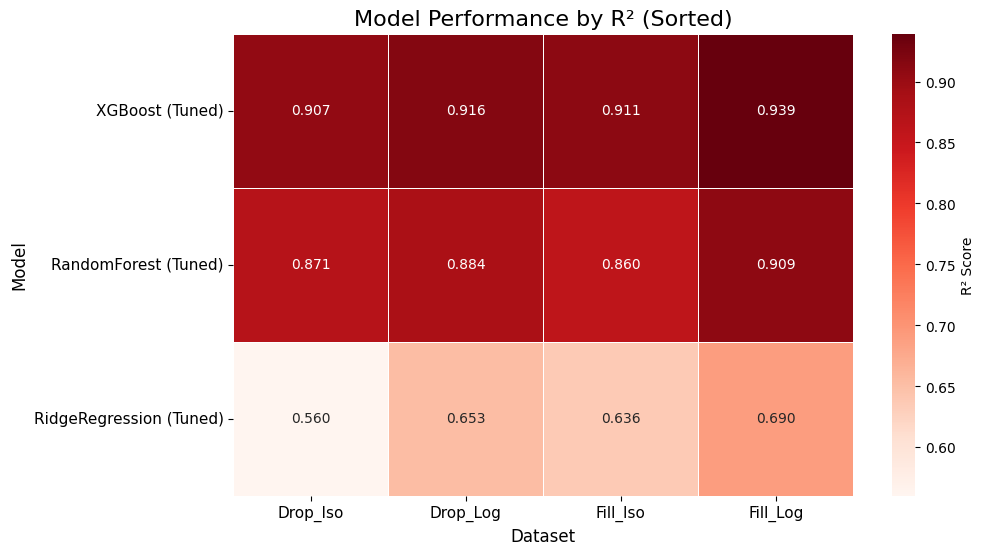

In [44]:
# Convert results_tuned to a DataFrame
results_tuned_df = pd.DataFrame(results_tuned)

# Check if results_tuned_df is empty
if results_tuned_df.empty:
    print("No tuned results available to create a heatmap.")
else:
    # Create a pivot table
    heatmap_data = results_tuned_df.pivot(index="Model", columns="Dataset", values="R²")

    heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
    heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
    heatmap_data.drop(columns="Avg R²", inplace=True)

    # Red theme color map
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="Reds",          # red theme
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "R² Score"}
    )

    plt.title("Model Performance by R² (Sorted)", fontsize=16)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()


In [ ]:
# Convert to DataFrame

df_no_tune = pd.DataFrame(results_no_hyper_tune)
df_tuned = pd.DataFrame(results_tuned)

df_no_tune.to_csv('../dataset/results_no_hyper_tune.csv', index=False)
df_tuned.to_csv('../dataset/result_tuned.csv', index=False)


# df_no_tune = pd.read_csv('../dataset/results_no_hyper_tune.csv') #use for called from saved result 
# df_tuned = pd.read_csv('../dataset/result_tuned.csv')

# Clean up model/dataset names
df_tuned["Model"] = df_tuned["Model"].str.replace(r" \(Tuned\)", "", regex=True)
df_tuned["Dataset"] = df_tuned["Dataset"].str.replace(r" Selected", "", regex=True)

# Merge for comparison
comparison = pd.merge(
    df_no_tune,
    df_tuned,
    on=["Dataset", "Model"],
    suffixes=("_NoTune", "_Tuned")
)

# Compute differences
comparison["Δ R²"] = comparison["R²_Tuned"] - comparison["R²_NoTune"]
comparison["Δ RMSE"] = comparison["RMSE_NoTune"] - comparison["RMSE_Tuned"]
comparison["Δ MAE"] = comparison["MAE_NoTune"] - comparison["MAE_Tuned"]
comparison["Δ PMAE"] = comparison["PMAE (%)_NoTune"] - comparison["PMAE (%)_Tuned"]

# Round for display
comparison = comparison.round(3)

# Sort by R² improvement
comparison.sort_values(by="Δ R²", ascending=False, inplace=True)
comparison.reset_index(drop=True, inplace=True)

# Style the comparison DataFrame
styled_comparison = comparison.style.format({
    "R²_NoTune": "{:.4f}",
    "RMSE_NoTune": "{:,.2f}",
    "MAE_NoTune": "{:,.2f}",
    "PMAE (%)_NoTune": "{:.2f}",
    "R²_Tuned": "{:.4f}",
    "RMSE_Tuned": "{:,.2f}",
    "MAE_Tuned": "{:,.2f}",
    "PMAE (%)_Tuned": "{:.2f}",
    "Δ R²": "{:.4f}",
    "Δ RMSE": "{:,.2f}",
    "Δ MAE": "{:,.2f}",
    "Δ PMAE": "{:.2f}"
}).background_gradient(subset=["R²_NoTune", "R²_Tuned", "Δ R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE_NoTune", "MAE_NoTune", "PMAE (%)_NoTune", "RMSE_Tuned", "MAE_Tuned", "PMAE (%)_Tuned"], cmap="Reds_r") \
  .background_gradient(subset=["Δ RMSE", "Δ MAE", "Δ PMAE"], cmap="Reds") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_comparison

,Dataset,Model,R²_NoTune,RMSE_NoTune,MAE_NoTune,PMAE (%)_NoTune,R²_Tuned,RMSE_Tuned,MAE_Tuned,PMAE (%)_Tuned,Δ R²,Δ RMSE,Δ MAE,Δ PMAE
0,Fill_Iso,XGBoost,0.8310,"4,984.69","3,024.49",17.07,0.9110,"3,611.20","1,875.35",10.59,0.0800,"1,373.49","1,149.14",6.48
1,Fill_Log,XGBoost,0.8930,"4,372.10","2,639.08",14.23,0.9390,"3,291.68","1,591.68",8.58,0.0460,"1,080.42","1,047.40",5.65
2,Drop_Iso,XGBoost,0.8700,"3,633.03","2,332.95",18.30,0.9070,"3,080.38","1,820.88",14.29,0.0360,552.65,512.07,4.01
3,Drop_Log,XGBoost,0.8920,"3,564.99","2,216.08",16.95,0.9160,"3,134.09","1,690.69",12.93,0.0240,430.90,525.39,4.02
4,Fill_Iso,RidgeRegression,0.6360,"7,307.91","5,252.39",29.65,0.6360,"7,307.91","5,252.39",29.65,0.0000,0.00,0.00,0.00
5,Drop_Iso,RidgeRegression,0.5600,"6,691.75","4,818.04",37.80,0.5600,"6,691.75","4,817.97",37.80,0.0000,0.00,0.07,0.00
6,Drop_Log,RidgeRegression,0.6540,"6,384.77","4,611.21",35.27,0.6540,"6,384.77","4,611.20",35.27,0.0000,0.00,0.01,0.00
7,Fill_Log,RidgeRegression,0.6900,"7,444.66","5,264.40",28.39,0.6900,"7,444.66","5,264.39",28.39,0.0000,0.00,0.01,0.00
8,Drop_Log,RandomForest,0.8920,"3,571.32","2,001.97",15.31,0.8840,"3,691.70","2,190.97",16.76,-0.0070,-120.38,-189.00,-1.45
9,Drop_Iso,RandomForest,0.8800,"3,497.22","2,038.81",15.99,0.8710,"3,628.14","2,231.00",17.50,-0.0090,-130.92,-192.19,-1.51


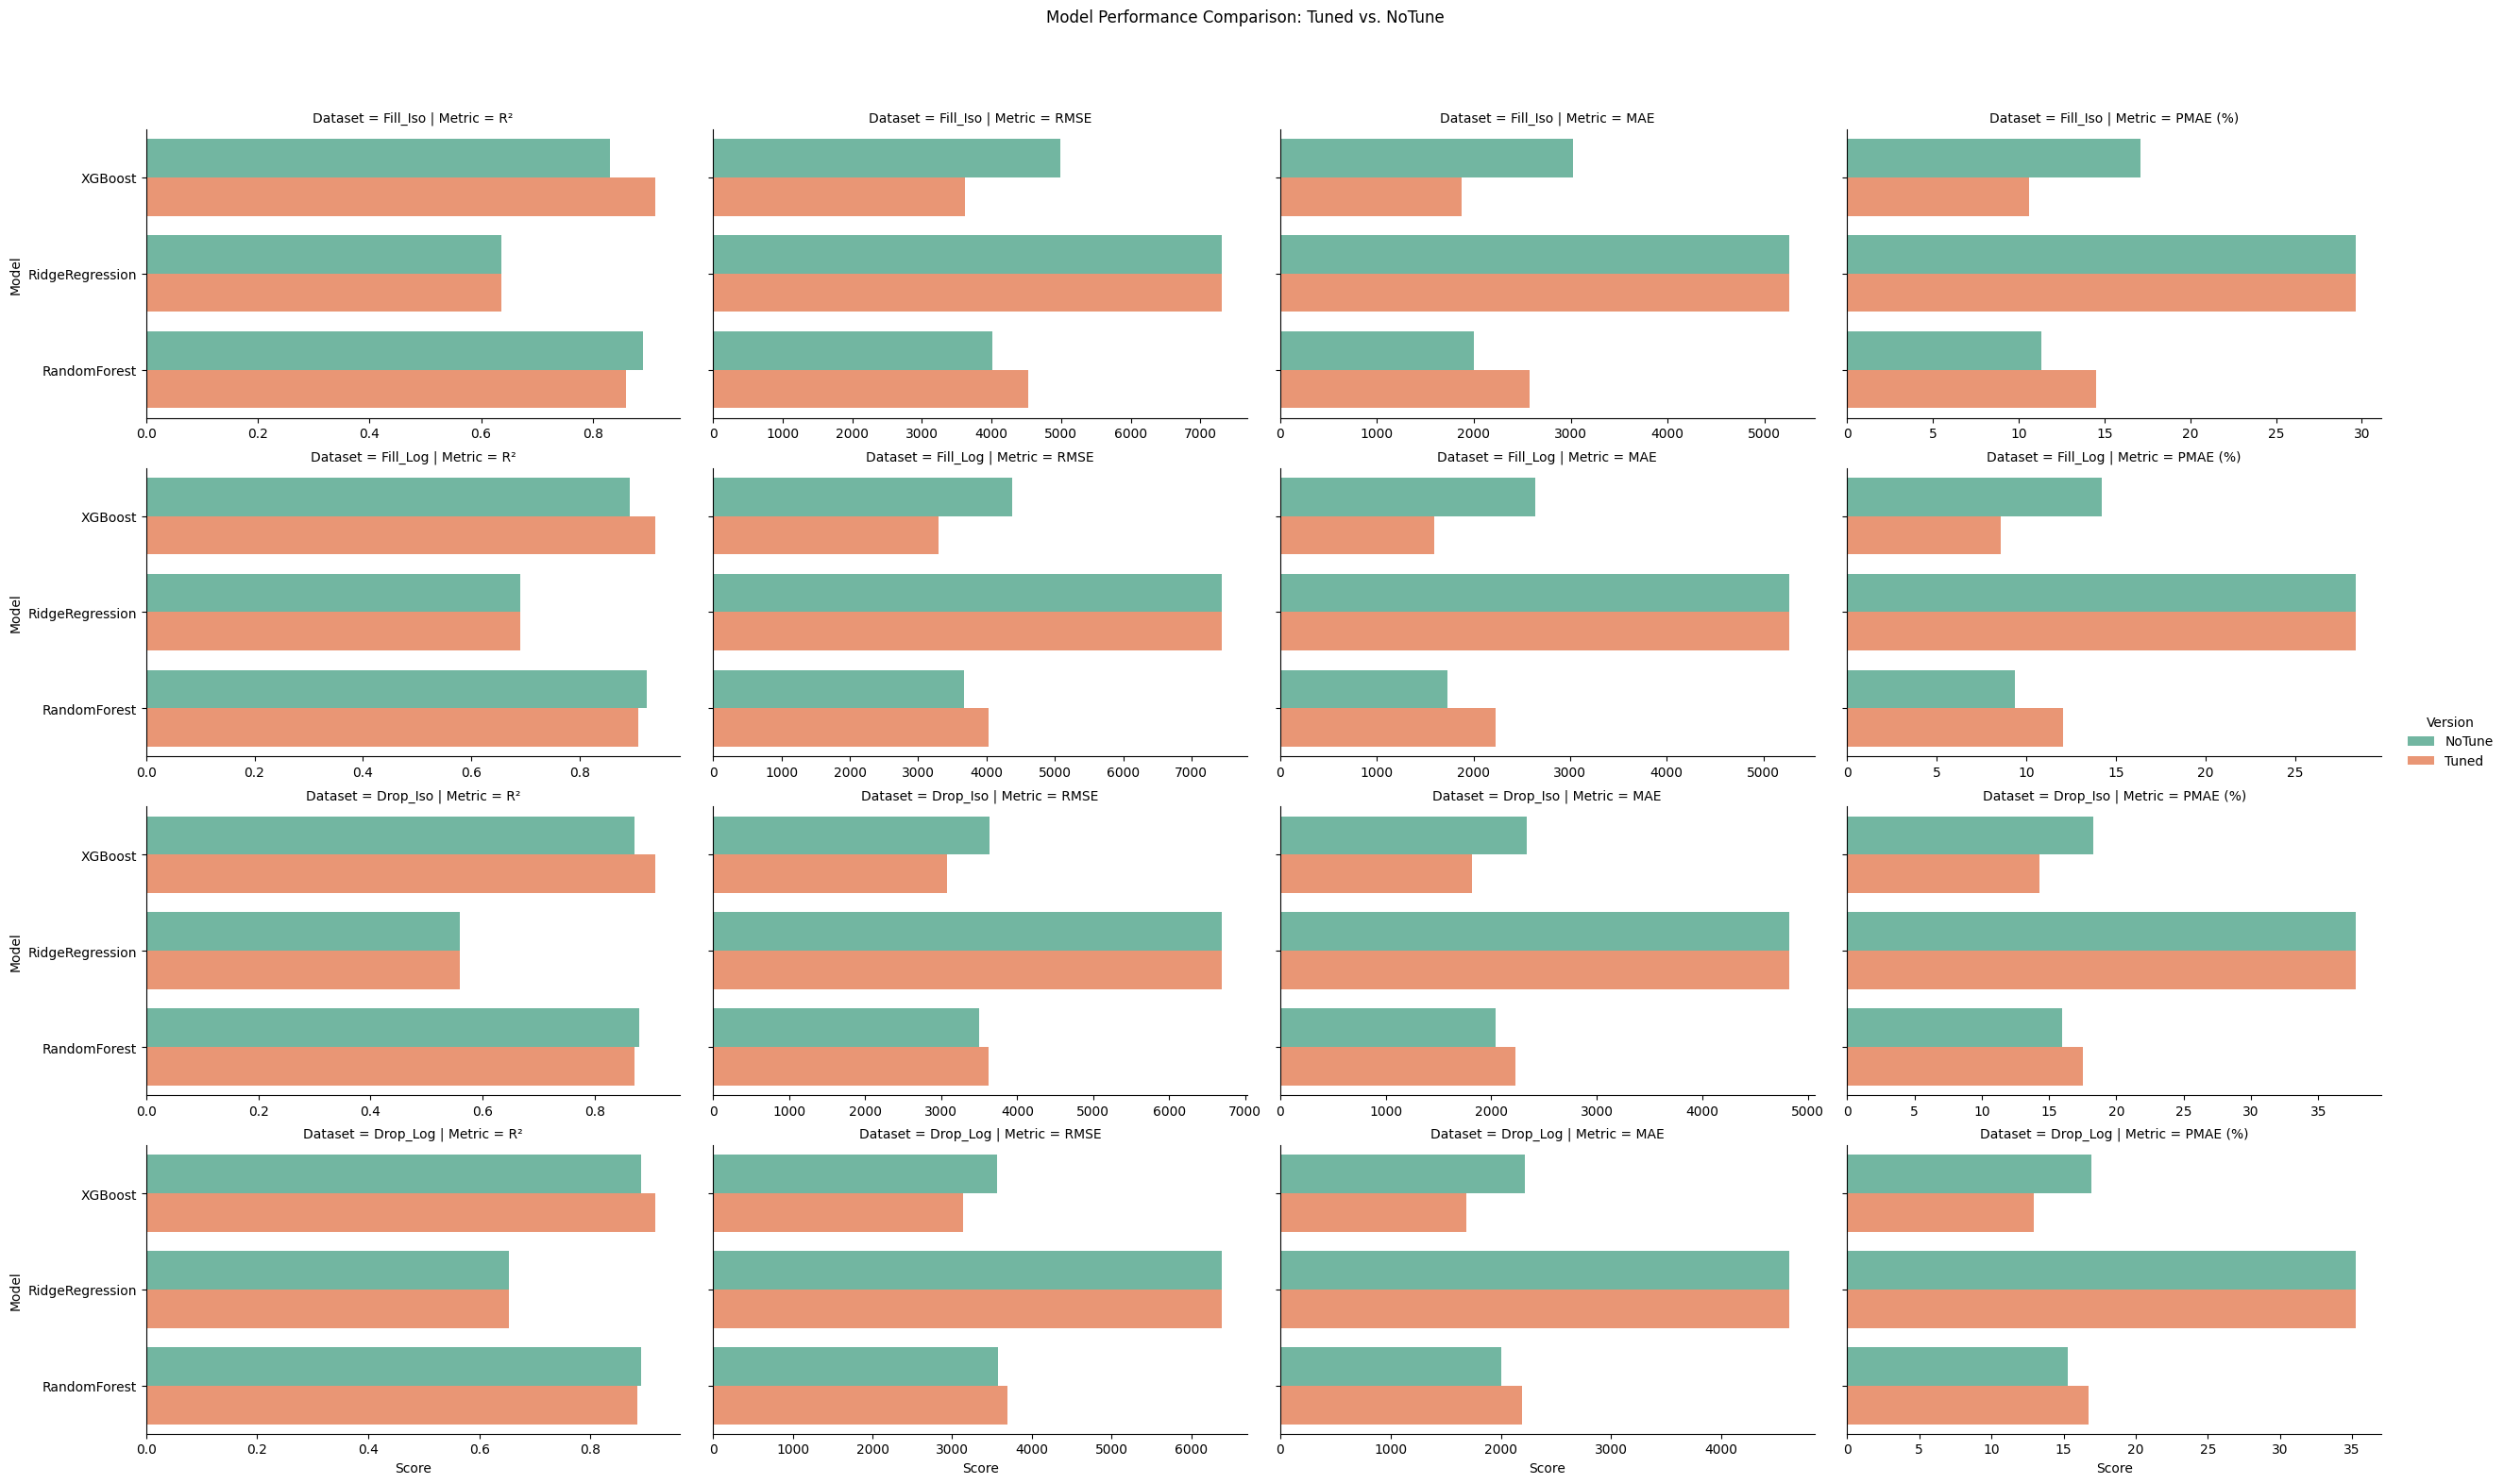

In [7]:
metrics = ["R²", "RMSE", "MAE", "PMAE (%)"]
melted = pd.melt(
    comparison,
    id_vars=["Dataset", "Model"],
    value_vars=[f"{m}_{sfx}" for m in metrics for sfx in ["NoTune", "Tuned"]],
    var_name="Metric_Version",
    value_name="Score"
)

# Split 'Metric_Version' into two columns: Metric and Version
melted[["Metric", "Version"]] = melted["Metric_Version"].str.extract(r"(.*)_((?:NoTune)|(?:Tuned))")
melted.drop(columns=["Metric_Version"], inplace=True)

# Plot
g = sns.catplot(
    data=melted,
    kind="bar",
    x="Score",
    y="Model",
    hue="Version",
    col="Metric",
    row="Dataset",
    palette="Set2",
    sharex=False,
    height=4,
    aspect=1.6
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Model Performance Comparison: Tuned vs. NoTune")
plt.show()